# Outlook

In this notebook, using BBRL, we code a simple version of the DQN algorithm without a replay buffer nor a target network so as to better understand the inner mechanisms. To understand this code, you need [to know more about BBRL](https://colab.research.google.com/drive/1_yp-JKkxh_P8Yhctulqm0IrLbE41oK1p?usp=sharing). You should first have a look at [the BBRL interaction model](https://colab.research.google.com/drive/1_yp-JKkxh_P8Yhctulqm0IrLbE41oK1p?usp=sharing), then [a first example](https://colab.research.google.com/drive/1Ui481r47fNHCQsQfKwdoNEVrEiqAEokh?usp=sharing).

The DQN algorithm is explained in [this video](https://www.youtube.com/watch?v=CXwvOMJujZk) and you can also read [the corresponding slides](http://pages.isir.upmc.fr/~sigaud/teach/dqn.pdf).

## Installation and Imports

### Installation

The BBRL library is [here](https://github.com/osigaud/bbrl).

This is OmegaConf that makes it possible that by just defining the `def run_dqn(cfg):` function and then executing a long `params = {...}` variable at the bottom of this colab, the code is run with the parameters without calling an explicit main.

More precisely, the code is run by calling

`config=OmegaConf.create(params)`

`run_dqn(config)`

at the very bottom of the colab, after starting tensorboard.

Below, we import standard python packages, pytorch packages and gym environments.

In [ ]:

try:
    from easypip import easyimport
except:
    !pip install easypip
    from easypip import easyimport

In [ ]:
import os
import functools
import time
from typing import Tuple

OmegaConf = easyimport("omegaconf").OmegaConf
torch = easyimport("torch")
bbrl_gym = easyimport("bbrl_gym")
import gym
import bbrl
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F


## BBRL imports

In [ ]:
from bbrl.agents.agent import Agent
from bbrl import get_arguments, get_class, instantiate_class

# The workspace is the main class in BBRL, this is where all data is collected and stored
from bbrl.workspace import Workspace

# Agents(agent1,agent2,agent3,...) executes the different agents the one after the other
# TemporalAgent(agent) executes an agent over multiple timesteps in the workspace, 
# or until a given condition is reached
from bbrl.agents import Agents, RemoteAgent, TemporalAgent

# AutoResetGymAgent is an agent able to execute a batch of gym environments
# with auto-resetting. These agents produce multiple variables in the workspace: 
# ’env/env_obs’, ’env/reward’, ’env/timestep’, ’env/done’, ’env/initial_state’, ’env/cumulated_reward’, 
# ... When called at timestep t=0, then the environments are automatically reset. 
# At timestep t>0, these agents will read the ’action’ variable in the workspace at time t − 1
from bbrl.agents.gymb import NoAutoResetGymAgent
# Not present in the A2C version...
from bbrl.utils.logger import TFLogger

def make_env(env_name):
    """Utility function to create an environment"""
    return gym.make(env_name)

## Definition of agents


See [this notebook](https://colab.research.google.com/drive/1Ui481r47fNHCQsQfKwdoNEVrEiqAEokh?usp=sharing) for previous explanations about agents and environment agents. We provide just a few details below.

In BBRL, the agent and the environment act within a **workspace** by *reading* and *writing* information:

- **reading**: by using `self.get((key, t))` to get the value of the tensor identified by `key` (a string)
- **writing**: by using `self.set((key, t), y)` to set the value of the tensor identified by `key` to `y`

**WARNING**: we are working with batches (i.e. several episodes at the same time)

An episode is depicted in the figure below.

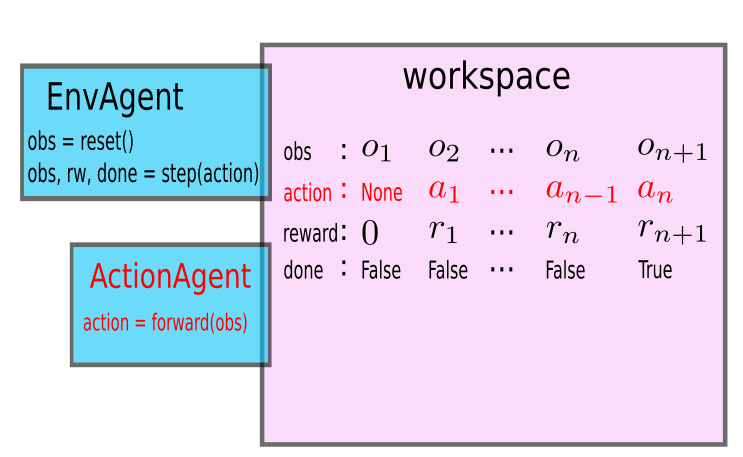

Note that we use a different reward indexing scheme here (see the [BBRL notebook](https://colab.research.google.com/drive/1Cld72_FBA1aMS2U4EsyV3LGZIlQC_PsC?usp=sharing#scrollTo=qXvH0jNADUsY)), where the reward obtained after performing action  $a_t$ from state $s_t$ is $r_t$.

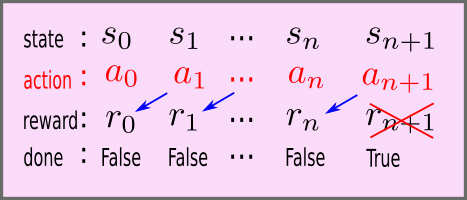

To showcase BBRL, let us go through the CartPole environment

In [ ]:
# We deal with 3 running episodes at a time (random seed 2139)
env_agent = NoAutoResetGymAgent(make_env, {'env_name': 'CartPole-v1'}, 3, 2139)
obs_size, action_dim = env_agent.get_obs_and_actions_sizes()
print(f"Environment: observation space in R^{obs_size} and action space {{1, ..., {action_dim}}}")

# Creates a new workspace
workspace = Workspace() 

# Execute the first step
env_agent(workspace, t=0)

# Our first set of observations (3 environments x obs. space 4)
obs = workspace.get("env/env_obs", 0)
obs

In [ ]:
# Sets the next action
action = torch.randint(0, action_dim, (3, ))
workspace.set("action", 0, action)
print(action)
env_agent(workspace, t=1)

# And do one step
workspace.get("env/env_obs", 0)

In [ ]:
# Let us now see the workspace

[x for x in workspace["env/env_obs", "env/reward", "env/done", "action"]]

You can observe that we have two time steps for each variable that are stored within tensors where the first dimension is time. The process above can be automatized with `Agents` and `TemporalAgent` as shown below - but first we have to create an agent that selects the actions (here, random)

In [ ]:
class RandomAgent(Agent):
    def __init__(self, action_dim):
        super().__init__()
        self.action_dim = action_dim

    def forward(self, t: int, choose_action=True, **kwargs):
        """An Agent can use self.workspace"""
        obs = self.get(("env/env_obs", t))
        action = torch.randint(0, self.action_dim, (len(obs), ))
        self.set(("action", t), action)

# Each agent will be run (in the order given when constructing Agents)
agents = Agents(env_agent, RandomAgent(action_dim))

# And TemporalAgent allows to run through time
t_agents = TemporalAgent(agents)

In [ ]:
# We can now run the agents throught time with a simple call...

workspace = Workspace()
t_agents(workspace, t=0, stop_variable="env/done", stochastic=True)

In [ ]:
# env/done tells us if the episode was finished or not
# here, with NoAutoReset, (1) we wait that all episodes are "done",
# and when an episode is finished the flag remains True
workspace["env/done"].shape, workspace["env/done"][-10:]

In [ ]:
# Our tensor of observations (time x #. episodes x observation state)
workspace["env/env_obs"].shape, workspace["env/env_obs"][-2:]

In [ ]:
# Our tensor of rewards (time x #. episodes)
workspace["env/reward"].shape, workspace["env/reward"][:5], workspace["env/reward"][-10:]

In [ ]:
# Our tensor of actions (time x #. episodes x observation state)

workspace["action"].shape, workspace["action"][-2:]

### The critic agent

The [DQN](https://daiwk.github.io/assets/dqn.pdf) algorithm is a critic only algorithm. Thus we just need a Critic agent (which will also be used to output actions) and an Environment agent. We reuse the `DiscreteQAgent` class that we have already explained in [this notebook](https://colab.research.google.com/drive/1Ui481r47fNHCQsQfKwdoNEVrEiqAEokh?usp=sharing).

In [ ]:
def build_mlp(sizes, activation, output_activation=nn.Identity()):
    """Helper function to build a multi-layer perceptron (function from $\mathbb R^n$ to $\mathbb R^p$)
    
    Args:
        sizes (List[int]): the number of neurons at each layer
        activation (nn.Module): a PyTorch activation function (after each layer but the last)
        output_activation (nn.Module): a PyTorch activation function (last layer)
    """
    layers = []
    for j in range(len(sizes) - 1):
        act = activation if j < len(sizes) - 2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j + 1]), act]
    return nn.Sequential(*layers)

In [ ]:
class DiscreteQAgent(Agent):
    """BBRL agent (discrete actions) based on a MLP"""
    def __init__(self, state_dim, hidden_layers, action_dim):
        super().__init__()
        self.model = build_mlp(
            [state_dim] + list(hidden_layers) + [action_dim], activation=nn.ReLU()
        )

    def forward(self, t: int, choose_action=True, **kwargs):
        """An Agent can use self.workspace"""

        # Retrieves the observation from the environment at time t
        obs = self.get(("env/env_obs", t))

        # Computes the critic (Q) values for the observation
        q_values = self.model(obs)

        # ... and sets the q-values (one for each possible action)
        self.set(("q_values", t), q_values)

        # Flag to toggle the fact that the action is chosen
        # by this agent; otherwise, we use a specific agent
        # (ex. epsilon-greedy) that implements the current policy,
        # see below (Exploration method)
        if choose_action:
            action = q_values.argmax(1)
            self.set(("action", t), action)

### Creating an Exploration method

As Q-learning, DQN needs some exploration to prevent too early convergence. Here we will use the simple $\epsilon$-greedy exploration method. The method is implemented as an agent which chooses an action based on the Q-values.

In [ ]:
class EGreedyActionSelector(Agent):
    def __init__(self, epsilon):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, t: int, **kwargs):
        # Retrieves the q values 
        # (matrix nb. of episodes x nb. of actions)
        q_values = self.get(("q_values", t))
        size, nb_actions = q_values.size()

        # Flag 
        is_random = torch.rand(size).lt(self.epsilon).float()
        random_action = torch.randint(low=0, high=nb_actions, size=(size,))
        max_action = q_values.max(1)[1]

        # Choose the action based on the is_random flag
        action = is_random * random_action + (1 - is_random) * max_action

        # Sets the action at time t
        self.set(("action", t), action.long())

### Training and evaluation environments

In actor-critic algorithms relying on a replay buffer, the actor can be trained at each step during an episode. Besides, the training signal is the reward obtained during these episodes. So it may seem natural to display a learning curve corresponding to the performance of the training agent along the set of training episodes.

But let us think of it. If the agent is changing during an episode, which agent are we truly evaluating? The one in the beginning of the episode? In the middle? In the end? We see that such evaluations based on an evolving agent makes no sense.

What makes more sense consists in training an agent for a number of steps, and then evaluating it on a few episode to determine the performance of that particular agent, then start again training. With this approach, the learning curve makes more sense, it shows the evolving performance of a succession of agents obtained after training sequences.

Separating training and evaluation provides additional opportunities. Often, we will train the agent using exploration, but we will evaluate it in a greedy, deterministic mode, as if the problem is truly an MDP, so deterministic policy can be optimal.

**We use two environments**: one for training and another one for evaluation. The same agent is connected to these two environments in two instances of TemporalAgent so that we train and evaluate the same network.

In the context of this notebook, we will only use the [NoAutoResetGymAgent](https://github.com/osigaud/bbrl/blob/96e58f6e01065f6a551039c4b9f7c1036b5523e6/bbrl/agents/gyma.py#L331) class, which is explained in [this notebook](https://colab.research.google.com/drive/1EX5O03mmWFp9wCL_Gb_-p08JktfiL2l5?usp=sharing).

In practice, it is more efficient to use an AutoResetGymAgent, as we do not want to waste time if the task is done in an environment sooner than in the others, but this is more involved so we keep this for [a later notebook](https://colab.research.google.com/drive/1H9_gkenmb_APnbygme1oEdhqMLSDc_bM?usp=sharing).

By contrast, for evaluation, we just need to perform a fixed number of episodes (for statistics), thus it is more convenient to use a NoAutoResetGymAgent with a set of environments and just run one episode in each environment. Thus we can use the `env/done` stop variable and take the average over the cumulated reward of all environments.

To keep the story simple, we use a single environment for training.

In [ ]:
def get_env_agents(cfg):
    """Returns a pair of environments (train / evaluation) based on a configuration `cfg` (see below)"""
    train_env_agent = NoAutoResetGymAgent(
        get_class(cfg.gym_env),
        get_arguments(cfg.gym_env),
        1,
        cfg.algorithm.seed,
    )
    eval_env_agent = NoAutoResetGymAgent(
        get_class(cfg.gym_env),
        get_arguments(cfg.gym_env),
        cfg.algorithm.nb_evals,
        cfg.algorithm.seed,
    )
    return train_env_agent, eval_env_agent

### Create the DQN agents

We use the power of BBRL here to define the agents:

- `Agents` defines is container that executes its of its contained agent in turn (so we can first run one step of the environment, then the critic and the explorer)
- `TemporalAgent` is just a container for a loop over time (it calls its agent and then step to the next timestep `t+1`)

Interestingly, the loop between the policy and the environment is first defined as a collection of agents, and then embedded into a single TemporalAgent.

In [ ]:
import copy

def create_dqn_agent(cfg, train_env_agent, eval_env_agent) -> Tuple[TemporalAgent, TemporalAgent]:
    # Get the observation / action state space dimensions
    obs_size, act_size = train_env_agent.get_obs_and_actions_sizes()

    # Our discrete Q-Agent    
    critic = DiscreteQAgent(obs_size, cfg.algorithm.architecture.hidden_size, act_size)

    # The agent used for training
    explorer = EGreedyActionSelector(cfg.algorithm.epsilon)
    q_agent = TemporalAgent(critic)
    tr_agent = Agents(train_env_agent, critic, explorer)
    train_agent = TemporalAgent(tr_agent)

    # The agent used for evaluation
    ev_agent = Agents(eval_env_agent, critic)
    eval_agent = TemporalAgent(ev_agent)
    
    train_agent.seed(cfg.algorithm.seed)
    return train_agent, eval_agent, q_agent

### The Logger class

The logger class below is not generic, it is specifically designed in the context of this notebook.

The logger parameters are defined below in `params = { "logger":{ ...`

In this notebook, the logger is defined as `bbrl.utils.logger.TFLogger` so as to use a tensorboard visualisation (see the parameters part below).
Note that the BBRL Logger is also saving the log in a readable format such that you can use `Logger.read_directories(...)` to read multiple logs, create a dataframe, and analyze many experiments afterward in a notebook for instance. 

The code for the different kinds of loggers is available in the [bbrl/utils/logger.py](https://github.com/osigaud/bbrl/blob/master/bbrl/utils/logger.py) file.

Having logging provided under the hood is one of the features where using RL libraries like BBRL will allow you to save time.

`instantiate_class` is an inner BBRL mechanism. The `instantiate_class`function is available in the [`bbrl/__init__.py`](https://github.com/osigaud/bbrl/blob/master/bbrl/__init__.py) file.

In [ ]:
class Logger():

    def __init__(self, cfg):
        self.logger = instantiate_class(cfg.logger)

    def add_log(self, log_string, loss, epoch):
        self.logger.add_scalar(log_string, loss.item(), epoch)

## Heart of the algorithm

### Computing the critic loss

The role of the `compute_critic_loss` function is to implement the Bellman backup rule. In Q-learning, this rule was written:

$$Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha [ r(s_t,a_t) + \gamma \max_a Q(s_{t+1},a) - Q(s_t,a_t)]$$

In DQN, the update rule $Q \leftarrow Q + \alpha [\delta] $ is replaced by a gradient descent step over the Q-network. 

We first compute a target value: $ target = r(s_t,a_t) + \gamma \max_a Q(s_{t+1},a)$ from a set of samples.

Then we get a TD error $\delta$ by substracting $Q(s_t,a_t)$ for these samples, 

and we use the squared TD error as a loss function: $ loss = (target - Q(s_t,a_t))^2$.

To implement the above calculation in BBRL, the difficulty consists in properly dealing with time indexes. We have left commented prints into the code so that you can have a look at the data structures during the computation.

The `compute_critic_loss` function receives rewards, q_values and actions as vectors (in practice, pytorch tensors) that have been computed over a complete episode.

We need to take `reward[:-1]`, which means all the rewards but the last one, because in BBRL, GymAgents repeat the reward at the last time step, as explained in [this notebook](https://colab.research.google.com/drive/1Cld72_FBA1aMS2U4EsyV3LGZIlQC_PsC?usp=sharing).

Conversely, to get $\max_a Q(s_{t+1}, a)$, we need to ignore the first of the max_q values, using `max_q[1:]`.

Note the `max_q[0].detach()` in the computation of the temporal difference target. First, the max_q[0] is because the max function returns both the max and the indexes of the max. Second, about the .detach(), the idea is that we compute this target as a function of $\max_a Q(s_{t+1}, a)$, but we do not want to apply gradient descent on this $\max_a Q(s_{t+1}, a)$, we will only apply gradient descent to the $Q(s_t, a_t)$ according to this target value. In practice, `x.detach()` detaches a computation graph from a tensor, so it avoids computing a gradient over this tensor.

The `must_bootstrap` tensor is used as a trick to deal with terminal states. If the state is terminal, $Q(s_{t+1}, a)$ does not make sense. Thus we need to ignore this term. So we multiply the term by `must_bootstrap`: if `must_bootstrap` is True (converted into a float, it becomes a 1), we get the term. If `must_bootstrap` is False (=0), we are at a terminal state, so we ignore the term. This trick is used in many RL libraries, e.g. SB3. In [this notebook](https://colab.research.google.com/drive/1erLbRKvdkdDy0Zn1X_JhC01s1QAt4BBj?usp=sharing) we explain how to compute `must_bootstrap` so as to properly deal with time limits. In this version we use full episodes, thus `must_bootstrap` will always be True for all steps but the last one.

To compute $Q(s_t,a_t)$ we use the `torch.gather()` function. This function is a little tricky to use, see [this page](https://medium.com/analytics-vidhya/understanding-indexing-with-pytorch-gather-33717a84ebc4) for useful explanations.

In particular, the q_vals output that we get is not properly conditioned, hence the need for the `qval[:-1]` (we ignore the last dimension).

Finally we just need to compute the difference target - qvals, square it, take the mean and send it back as the loss.

In [ ]:
# Compute the temporal difference loss from a dataset to update a critic

# For the tensor dimensions
# T = maximum number of time steps
# B = number of episodes run in parallel 
# A = state space dimension

def compute_critic_loss(cfg, reward: torch.Tensor, must_bootstrap: torch.Tensor, q_values: torch.Tensor, action: torch.LongTensor):
    """_summary_

    Args:
        cfg (_type_): _description_
        reward (torch.Tensor): A (T x B) tensor containing the rewards
        must_bootstrap (torch.Tensor): a (T x B) tensor containing 0 if the episode is completed at time $t$
        q_values (torch.Tensor): a (T x B x A)
        action (torch.LongTensor): a (T) long tensor containing the chosen action

    Returns:
        torch.Scalar: The DQN loss
    """
    # We compute the max of Q-values over all actions (dimension 1, hence max(1))
    # and detach (so that this part of the computation graph is not included
    # in the gradient backpropagation)
    max_q = q_values.max(2)[0].detach()  # Results in a (T x B) tensor

    # To get the max of Q(s_{t+1}, a), we take max_q[1:]
    # The same about must_bootstrap. 
    target = (
        reward[:-1] + cfg.algorithm.discount_factor * max_q[1:] * must_bootstrap[1:].int()
    )

    # To get Q(s,a), we use torch.gather along the 3rd dimension (the action)
    qvals = q_values.gather(2, action.unsqueeze(-1)).squeeze(-1)

    # Compute the temporal difference (use must_boostrap as to mask out finished episodes)
    td = (target - qvals[:-1]) * must_bootstrap[:-1].int()
   
    # Compute critic loss
    td_error = td**2
    critic_loss = td_error.mean()
    # print(critic_loss)
    
    return critic_loss



### Setting up the optimizer

The optimizer is used to tune the parameters of the DQN agent.

In [ ]:
# Configure the optimizer over the q agent
def setup_optimizer(cfg, q_agent):
    optimizer_args = get_arguments(cfg.optimizer)
    parameters = q_agent.parameters()
    optimizer = get_class(cfg.optimizer)(parameters, **optimizer_args)
    return optimizer

## Main training loop

Note that everything about the shared workspace between all the agents is completely hidden under the hood. This results in a gain of productivity, at the expense of having to dig into the BBRL code if you want to understand the details, change the multiprocessing model, etc.

### Agent execution

This is the tricky part with BBRL, the one we need to understand in detail. The difficulty lies in the copy of the last step and the way to deal with the n_steps return.

The call to `train_agent(workspace, t=1, n_steps=cfg.algorithm.n_timesteps - 1, stochastic=True)` makes the agent run a number of steps in the workspace. In practice, it calls the [`__call__(...)`](https://github.com/osigaud/bbrl/blob/master/bbrl/agents/agent.py#L54) function which makes a forward pass of the agent network using the workspace data and updates the workspace accordingly.

Now, if we start at the first epoch (`epoch=0`), we start from the first step (`t=0`). But when subsequently we perform the next epochs (`epoch>0`), we must not forget to cover the transition at the border between the previous epoch and the current epoch. To avoid this risk, we copy the information from the last time step of the previous epoch into the first time step of the next epoch. This is explained in more details in [this notebook](https://colab.research.google.com/drive/1W9Y-3fa6LsPeR6cBC1vgwBjKfgMwZvP5?usp=sharing).

Note that we `optimizer.zero_grad()`, `loss.backward()` and `optimizer.step()` lines. 

`optimizer.zero_grad()` is necessary to cancel all the gradients computed at the previous iterations

In [ ]:
def run_dqn(cfg):
    # 1)  Build the  logger
    logger = Logger(cfg)
    best_reward = -10e9

    # 2) Create the environment agent
    train_env_agent = NoAutoResetGymAgent(
        get_class(cfg.gym_env),
        get_arguments(cfg.gym_env),
        cfg.algorithm.n_envs, 
        cfg.algorithm.seed,
    )
    eval_env_agent = NoAutoResetGymAgent(
        get_class(cfg.gym_env),
        get_arguments(cfg.gym_env),
        # We evaluate on various episodes all at once
        cfg.algorithm.nb_evals,
        cfg.algorithm.seed,
    )

    # 3) Create the DQN-like Agent
    train_agent, eval_agent, q_agent = create_dqn_agent(
        cfg, train_env_agent, eval_env_agent
    )

    # Note that no parameter is needed to create the workspace.
    # In the training loop, calling the train_agent
    # will take the workspace as parameter

    # 6) Configure the optimizer
    optimizer = setup_optimizer(cfg, q_agent)
    nb_steps = 0
    tmp_steps = 0
    nb_measures = 0

    while nb_measures < cfg.algorithm.nb_measures:
        train_workspace = Workspace()

        # Run 
        train_agent(train_workspace, t=0, stop_variable="env/done", stochastic=True)

        q_values, done, truncated, reward, action = train_workspace[
            "q_values", "env/done", "env/truncated", "env/reward", "action"
        ]

        nb_steps += len(action.flatten())
        
        # Determines whether values of the critic should be propagated
        # True if the episode reached a time limit or if the task was not done
        # See https://colab.research.google.com/drive/1erLbRKvdkdDy0Zn1X_JhC01s1QAt4BBj
        must_bootstrap = torch.logical_or(~done, truncated)
        
        # Compute critic loss
        critic_loss = compute_critic_loss(cfg, reward, must_bootstrap, q_values, action)

        # Store the loss for tensorboard display
        logger.add_log("critic_loss", critic_loss, nb_steps)

        optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            q_agent.parameters(), cfg.algorithm.max_grad_norm
        )
        optimizer.step()

        if nb_steps - tmp_steps > cfg.algorithm.eval_interval:
            nb_measures += 1
            tmp_steps = nb_steps
            eval_workspace = Workspace()  # Used for evaluation
            eval_agent(
                eval_workspace, t=0, stop_variable="env/done", choose_action=True
            )
            rewards = eval_workspace["env/cumulated_reward"][-1]
            mean = rewards.mean()
            logger.add_log("reward", mean, nb_steps)
            print(f"nb_steps: {nb_steps}, reward: {mean}")
            if cfg.save_best and mean > best_reward:
                best_reward = mean
                directory = "./dqn_critic/"
                if not os.path.exists(directory):
                    os.makedirs(directory)
                filename = directory + "dqn_" + str(mean.item()) + ".agt"
                eval_agent.save_model(filename)
                
    return train_agent, eval_agent, q_agent

## Definition of the parameters

The logger is defined as `bbrl.utils.logger.TFLogger` so as to use a tensorboard visualisation.

In [ ]:
params={
  "save_best": False,
  "logger":{
    "classname": "bbrl.utils.logger.TFLogger",
    "log_dir": "./tmp/dqn-simple-" + str(time.time()),
    "cache_size": 10000,
    "every_n_seconds": 10,
    "verbose": False,    
    },

  "algorithm":{
    "seed": 3,
    "max_grad_norm": 0.5,
    "epsilon": 0.02,
    "n_envs": 8,
    "n_steps": 32,
    "eval_interval": 2000,
    "nb_measures": 200,
    "nb_evals": 10,
    "discount_factor": 0.99,
    "architecture":{"hidden_size": [128, 128]},
  },
  "gym_env":{
    "classname": "__main__.make_env",
    "env_name": "CartPole-v1",
  },
  "optimizer":
  {
    "classname": "torch.optim.Adam",
    "lr": 2e-3,
  }
}



### Launching tensorboard to visualize the results

# For Colab - otherwise, it is easier and better to launch tensorboard from
# the terminal
# tensorboard --logdir ./tmp
if get_ipython().__class__.__module__ == "google.colab._shell":
    # %load_ext tensorboard
    # %tensorboard --logdir ./tmp
else:
    import sys
    import os
    import os.path as osp
    print(f"Launch tensorboard from the shell:\n{osp.dirname(sys.executable)}/tensorboard --logdir={os.getcwd()}/tmp")
```

config=OmegaConf.create(params)
torch.manual_seed(config.algorithm.seed)
train_agent, eval_agent, q_agent = run_dqn(config)
```

The version used in this colab uses $< s_t, a_t, r_t, s_{t+1}>$ samples. As an exercise, you may switch to $< s_t, a_t, r_{t+1}, s_{t+1}>$ samples, going back to the standard SaLinA notation. For that, replace the import to `bbrl.agents.gyma` instead of `gymb`, and change the temporal difference update rule (in `compute_critic_loss(...)`) accordingly. See [this notebook](https://colab.research.google.com/drive/1Cld72_FBA1aMS2U4EsyV3LGZIlQC_PsC?usp=sharing) for more explanations.

## What's next?

To get a full DQN, we need to do the following:
- Add a replay buffer. We can add a replay buffer independently from the target network. The version with a replay buffer and no target network corresponds to [the NQF algorithm](https://link.springer.com/content/pdf/10.1007/11564096_32.pdf). This will be the aim of the next notebook.
- Before adding the replay buffer, we will first move to a version of DQN which uses the AutoResetGymAgent. This will be the aim of the next notebook too.
- We should also add a few extra-mechanisms which are present in the full DQN version: starting to learn once the replay buffer is full enough, decreasing the exploration rate epsilon...
<!-- - We could also add visualization tools to visualize the learned Q network, by using the `plot_critic` function available in [`bbrl.visu.visu_critics`](https://github.com/osigaud/bbrl/blob/96e58f6e01065f6a551039c4b9f7c1036b5523e6/bbrl/visu/visu_critics.py#L13) -->